In [1]:
!pip install pyvis

<AxesSubplot: xlabel='time'>

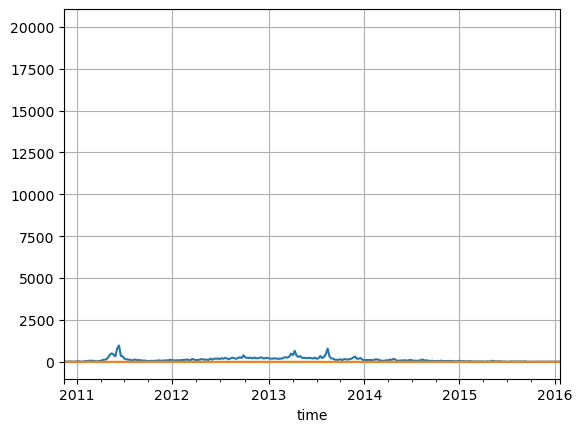

In [2]:
import pandas as pd
import datetime

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Read the dataset
data = pd.read_csv('soc-sign-bitcoinotc.csv', names=['source', 'target', 'rating', 'time'])

# Transform the ‘time’ column into a date-time format
data['time'] = data['time'].apply(lambda x: datetime.datetime.fromtimestamp(x))

# Analyze the dataset using the describe function
data.describe()

# Aggregate the ‘time’ column by weeks and plot the total row counts as a time series graph
data.resample('1W', on='time')['time'].count().plot()

# Aggregate the ‘time’ column by weeks and plot the average ratings as a time series graph
data.resample('1W', on='time')['rating'].mean().plot()

# Plot the histogram of ratings
data['rating'].hist(bins=21)

# Plot the histogram of average ratings grouped by targeted users
data.groupby('target').mean()['rating'].hist()

In [3]:
import networkx as nx

# Create a directed graph object using the NetworkX
G = nx.DiGraph()

# Add all rows as edges to the graph and attach the ratings to the edges as weight
for index, row in data.iterrows():
    node1 = row['source']
    node2 = row['target']
    rating = row['rating']
    G.add_edge(node1, node2, weight=rating)

# Alternative way of creating the graph above
# G = nx.from_pandas_edgelist(data, source='source', target='target', edge_attr='rating', create_using=nx.DiGraph())

# Printing out the number of nodes
nodes = list(G.nodes)
num_nodes = len(nodes)
print(f"The social graph contains {num_nodes} nodes.")

# Creating Feature DataFrame
# Feature 1: Average rating of each user
feature_df = data.groupby('target').mean()['rating'].reset_index()

# Feature 2: The average of inbound users’ average ratings for each target user
joined_df = data.merge(feature_df, left_on='source', right_on='target', how='left')
avg_rating_of_in_degrees = joined_df.groupby('target_x').mean()['rating_y'].reset_index().fillna(0)
feature_df = feature_df.merge(avg_rating_of_in_degrees, left_on='target', right_on='target_x', how='left')
feature_df=feature_df.drop('target_x',axis=1).rename(columns={'rating_y': 'avg_rating_in_degrees'})

# Feature 3 & 4: in-degree and out-degree of each target user
feature_df['in_degree'] = feature_df['target'].apply(lambda x: G.in_degree(x))
feature_df['out_degree'] = feature_df['target'].apply(lambda x: G.out_degree(x))

# Feature 5: Pagerank value of each target user
pr = nx.pagerank_numpy(G)
feature_df['pagerank'] = feature_df['target'].apply(lambda x: pr[x])
feature_df = feature_df.set_index('target')
feature_df.describe()

The social graph contains 5881 nodes.


/var/folders/ld/bth865bn75s3_wyszcgrw53h0000gn/T/ipykernel_42158/2802864480.py:36: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  pr = nx.pagerank_numpy(G)
/Users/udaymukhija/opt/anaconda3/lib/python3.9/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:354: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = google_matrix(


,rating,avg_rating_in_degrees,in_degree,out_degree,pagerank
count,5858.000,5858.000,5858.000,5858.000,5858.000
mean,0.729,1.498,6.076,6.068,-892688.994
std,2.827,1.250,17.706,21.127,148415400666.508
min,-10.000,-10.000,1.000,0.000,-3492371017436.619
25%,1.000,1.223,1.000,1.000,-386805144.423
50%,1.000,1.644,2.000,2.000,232481816.901
75%,1.700,2.022,5.000,4.000,577471710.272
max,10.000,8.000,535.000,763.000,4824975347654.064


In [4]:
from sklearn.cluster import KMeans

# Apply normalization to all columns in feature_df to bring all features between 0 and 1
for col in feature_df.columns:
    feature_df[col] = ((feature_df[col] - feature_df[col].min()) / (feature_df[col].max() - feature_df[col].min()))

# Create a k-means model with n_clusters = 5 and random_state = 0
kmeans_model = KMeans(n_clusters=5, random_state=0).fit(feature_df)

# Predict the clusters
feature_df['cluster'] = kmeans_model.predict(feature_df)

# Print out the size of clusters and averages of each feature grouped by clusters
cluster_sizes = feature_df.groupby('cluster').size().reset_index().rename(columns={0: 'size'})
cluster_attributes = feature_df.groupby('cluster').agg('mean')
cluster_attributes = cluster_sizes.join(cluster_attributes)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pyvis.network import Network

# Create a new directed graph object, including only the first 100 rows
Gsmall = nx.from_pandas_edgelist(data[:100], source='source', target='target', edge_attr='rating', create_using=nx.DiGraph())
np.random.seed(0)

# Visualize the new graph using the draw function
nx.draw(Gsmall, node_size=5)
plt.show()

# Add color to the edges of the NetworkX draw based on the user ratings
edges, weights = zip(*nx.get_edge_attributes(Gsmall, 'rating').items())
nx.draw(Gsmall, node_size=5, edgelist=edges, edge_color=weights)
plt.legend()
plt.show()

# Create another visualization using the NetworkX object of the pyvis library
net = Network(directed=True, notebook=True) #If it runs on a notebook, you should add notebook=True.
net.from_nx(Gsmall)
net.show('100_node_graph.html')